In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
df = pd.read_csv('Microsoft_Stock.csv',index_col='Date')
df.index = pd.to_datetime(df.index)
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455
2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012
2021-03-31 16:00:00,232.91,239.10,232.39,235.77,43623471


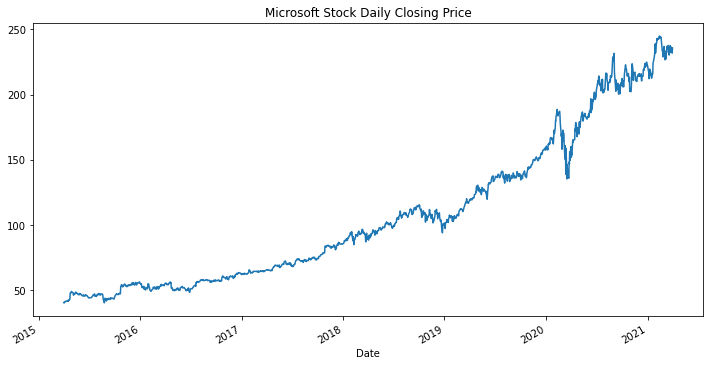

In [55]:
fig = df['Close'].plot(figsize=(12,6), title= 'Microsoft Stock Daily Closing Price')
plt.savefig('Microsoft_stock_closing_price.jpg')

In [56]:
# General Info
df['daily return'] = df['Close'] / df['Close'].shift(1) -1
print('Average Daily Return:', df['daily return'].mean())
cagr = (df['Close'][-1]/df['Close'][1])**(1/df['Close'].count()) -1
print('CAGR:', cagr)
print('Standard Deviation:', df['daily return'].std())

Average Daily Return: 0.0013155196063074832
CAGR: 0.0011699449073729884
Standard Deviation: 0.017449162219778668


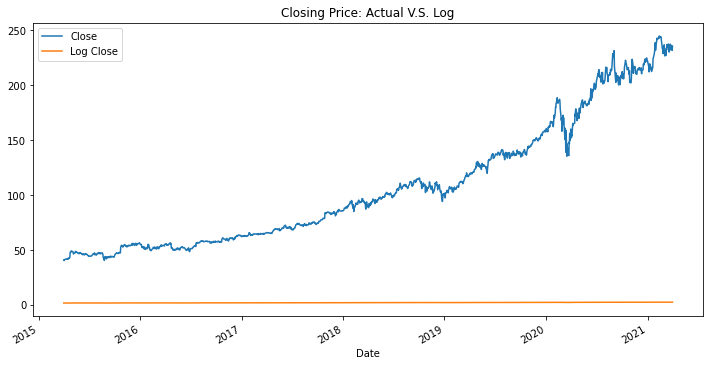

In [57]:
# Log Transformation
df['Log Close'] = np.log10(df['Close'])
fig = df[['Close','Log Close']].plot(figsize=(12,6), title= 'Closing Price: Actual V.S. Log')
plt.savefig('Actual_vs_log.jpg')

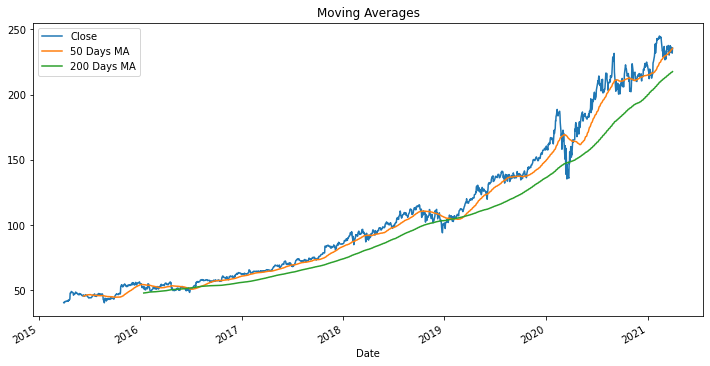

In [58]:
# Seasonality Adjustment
df['50 Days MA'] = df['Close'].rolling(50).mean()
df['200 Days MA'] = df['Close'].rolling(200).mean()
fig = df[['Close','50 Days MA','200 Days MA']].plot(figsize=(12,6),title='Moving Averages')
plt.savefig('Moving Averages.jpg')

<Figure size 432x288 with 0 Axes>

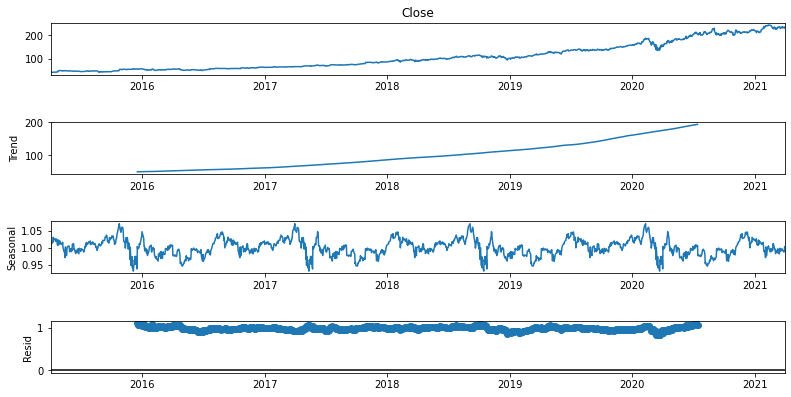

In [59]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['Close'], model='multiplicative',period=360)
fig = plt.figure()  
fig = decomp.plot()  
fig.set_size_inches(12, 6)
plt.savefig('Decomposition')

C:\Users\Zach\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Zach\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\Zach\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


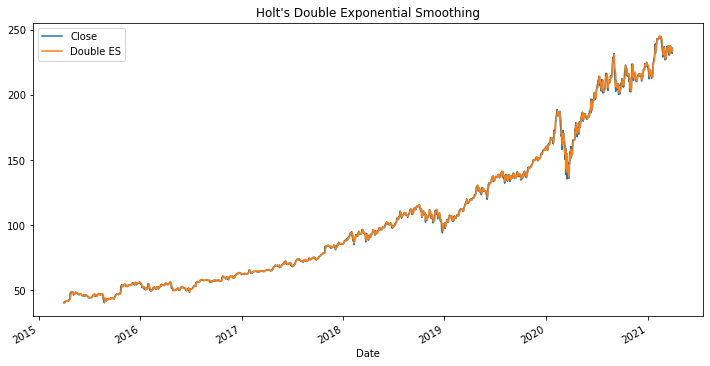

In [60]:
# Holt's Double Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
holt_train = ExponentialSmoothing(df['Close'], trend='mul').fit()
df['Double ES'] = holt_train.fittedvalues
fig = df[['Close','Double ES']].plot(figsize=(12,6),title="Holt's Double Exponential Smoothing")
plt.savefig("Holt's Double Exponential Smoothing.jpg")

In [61]:
# Fitness Check
from sklearn.metrics import mean_squared_error
print('MSE:', mean_squared_error(df['Close'],df['Double ES']))
print('RMSE', np.sqrt(mean_squared_error(df['Close'],df['Double ES'])))

MSE: 5.159654568511154
RMSE 2.2714873031807055


C:\Users\Zach\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


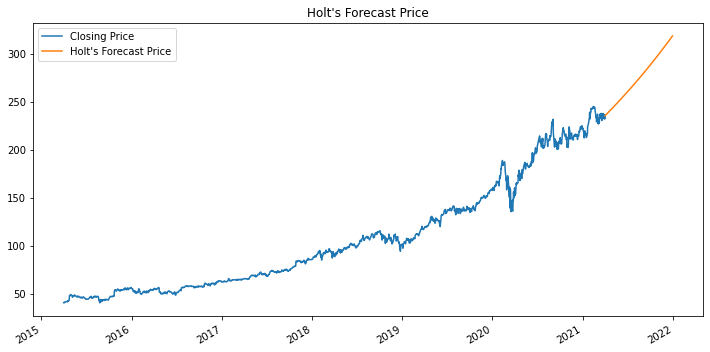

In [62]:
# Forecast Next Periods
import datetime 
import holidays
us_holidays = holidays.US()
start = datetime.datetime.strptime('2021-04-01','%Y-%m-%d')
end = datetime.datetime.strptime('2021-12-31','%Y-%m-%d')
date_generated = [start + datetime.timedelta(days=x) for x in range((end-start).days)]
for each in date_generated:
    if each in holidays.US(years = 2021).items():
        date_generated.pop(each)
holt_forecast = holt_train.forecast(len(date_generated))
holt_forecast.index = date_generated
df_forecast = pd.concat([df['Close'],holt_forecast],axis=1)
df_forecast.columns = ['Closing Price',"Holt's Forecast Price"]
fig = df_forecast.plot(figsize=(12,6), title= "Holt's Forecast Price")
plt.savefig("Holt's Forecast Price")

In [63]:
# Forecast Values
print('Forecasted Next Period Price:', holt_forecast[0])
print('Forecasted 50 Days Price:', holt_forecast[49])
print('Forecasted Year End Price:', holt_forecast[-1])
daily_return = holt_forecast / holt_forecast.shift(1) -1
print('Average Daily Return:', daily_return.mean())
cagr = (holt_forecast[-1]/holt_forecast[1])**(1/holt_forecast.count()) -1
print('CAGR:', cagr)

Forecasted Next Period Price: 235.34982859613308
Forecasted 50 Days Price: 248.4639478809082
Forecasted Year End Price: 318.3597951186331
Average Daily Return: 0.001107239404956049
CAGR: 0.0010991529254376076


In [64]:
# 50 Days Moving Average
df['50 Days MA'].tail()

Date
2021-03-25 16:00:00    233.9160
2021-03-26 16:00:00    234.3188
2021-03-29 16:00:00    234.7632
2021-03-30 16:00:00    235.1472
2021-03-31 16:00:00    235.5338
Name: 50 Days MA, dtype: float64

In [65]:
# Fitness Check
print('MSE:', mean_squared_error(df['Close'][50:],df['50 Days MA'][50:]))
print('RMSE', np.sqrt(mean_squared_error(df['Close'][50:],df['50 Days MA'][50:])))

MSE: 45.738012207885426
RMSE 6.7629884080845075


In [66]:
# Forecast Next Periods
raw_data = df['Close'].to_list()
first_data = sum(raw_data[-50:])/50
ma_forecast = [first_data]
for i in range(len(date_generated)-1):
    if len(ma_forecast) < 50:
        new_data = sum(raw_data[-50+len(ma_forecast):]) + sum(ma_forecast)
    else:
        new_data = sum(ma_forecast[-50:])
    new_data /= 50
    ma_forecast.append(new_data)
ma_series = pd.Series(ma_forecast,index=date_generated)
ma_series.name = 'MA Forecast Price'
df_forecast = pd.concat([df_forecast, ma_series], axis=1)

In [67]:
# Forecast Values
print('Forecasted Next Period Price:', ma_forecast[0])
print('Forecasted 50 Days Price:', ma_forecast[49])
print('Forecasted Year End Price:', ma_forecast[-1])
daily_return = ma_series / ma_series.shift(1) -1
print('Average Daily Return:', daily_return.mean())
cagr = (ma_forecast[-1]/ma_forecast[1])**(1/len(ma_forecast)) -1
print('CAGR:', cagr)

Forecasted Next Period Price: 235.53379999999993
Forecasted 50 Days Price: 235.4290229116163
Forecasted Year End Price: 235.24344866090584
Average Daily Return: -4.498245211439993e-06
CAGR: -7.969133332674794e-06


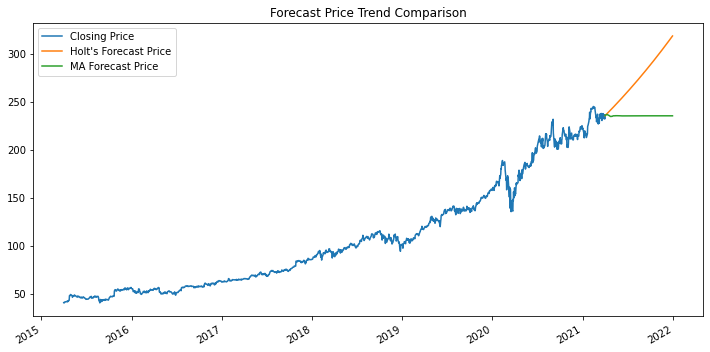

In [68]:
fig = df_forecast[['Closing Price',"Holt's Forecast Price",'MA Forecast Price']].plot(figsize=(12,6),title= 'Forecast Price Trend Comparison')
plt.savefig('Forecast Price Trend Comparison')

[*********************100%***********************]  1 of 1 completed


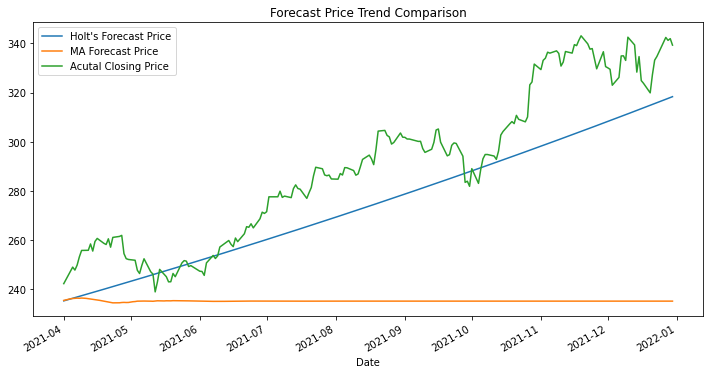

In [88]:
import yfinance as yf
closing_df = yf.download('MSFT', '2021-04-01', '2021-12-31')['Close']
df_forecast[["Holt's Forecast Price",'MA Forecast Price']].plot(figsize=(12,6),title= 'Forecast Price Trend Comparison')
closing_df.plot(label='Acutal Closing Price')
plt.legend()